In [1]:
import tweepy
import pandas as pd
import time

### Twitter Credentials (Updating the twitter credentials in the twitter_credentials.csv file and loading it here)

In [2]:
credentials_df = pd.read_csv('twitter_credentials.csv',header=None,names=['Name','Key'])
credentials_df

,Name,Key
0,consumer_key,CvbMui2D4MuIK5dxzT0mR03s8
1,consumer_secret,YkrRUAfCCi9h0mDzThuzNb5d7CSDjQwb4SwDzQWaErVopt...
2,access_token,895342019668619264-lQ9NRAL8URrYfIpRSS1fbVMcUpk...
3,access_secret,naWmOWyX6XDN8f1khdmh2KodtOIr6DOmEjqipyQyetUgV


In [3]:
consumer_key = credentials_df.loc[credentials_df['Name']=='consumer_key','Key'].iloc[0]
consumer_secret = credentials_df.loc[credentials_df['Name']=='consumer_secret','Key'].iloc[0]
access_token = credentials_df.loc[credentials_df['Name']=='access_token','Key'].iloc[0]
access_token_secret = credentials_df.loc[credentials_df['Name']=='access_secret','Key'].iloc[0]

In [4]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret) 
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [125]:
tweet_url = pd.read_csv("Biden/Urls/biden_tweets_oct_urls.txt", index_col= None, header = None, names = ["links"])
tweet_url.head()

,links
0,https://twitter.com/muratokcu32/status/1321965...
1,https://twitter.com/WightBuffalo/status/132196...
2,https://twitter.com/Fragola_Girl/status/132196...
3,https://twitter.com/MaggieC47929176/status/132...
4,https://twitter.com/gone_galt/status/132196490...


In [126]:
af = lambda x: x["links"].split("/")[-1]
tweet_url['id'] = tweet_url.apply(af, axis=1)
tweet_url.head()

,links,id
0,https://twitter.com/muratokcu32/status/1321965...,1321965028837380104
1,https://twitter.com/WightBuffalo/status/132196...,1321964974630006784
2,https://twitter.com/Fragola_Girl/status/132196...,1321964950030438400
3,https://twitter.com/MaggieC47929176/status/132...,1321964907403726848
4,https://twitter.com/gone_galt/status/132196490...,1321964901040992256


In [127]:
ids = tweet_url['id'].tolist()

In [128]:
total_count = len(ids)
chunks = (total_count - 1) // 50 + 1

In [129]:
total_count

238400

In [130]:
def fetch_tw(ids):
    list_of_tw_status = api.statuses_lookup(ids, tweet_mode= "extended")
    empty_data = pd.DataFrame()
    for status in list_of_tw_status:
            tweet_elem = {"tweet_id": status.id,
                     "screen_name": status.user.screen_name,
                     "tweet":status.full_text,
                     "date":status.created_at,
                     "coordinates":status.coordinates,
                     "location": status.user.location,
                     "place": status.place
                        }
            empty_data = empty_data.append(tweet_elem, ignore_index = True)
    empty_data.to_csv("Biden/Tweets/biden_tweets_oct.csv", mode="a")

In [131]:
for i in range(chunks):
        batch = ids[i*50:(i+1)*50]
        result = fetch_tw(batch)

## Sentimental Analysis

In [12]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib
import matplotlib.pyplot as plt

In [13]:
df1 = pd.read_csv('trump_tweets_jan1.csv',lineterminator='\n')
df1

,Unnamed: 0,coordinates,date,location,place,screen_name,tweet,tweet_id
0,0.0,NaN,2020-01-13 23:59:43,"Nashville, Tennessee",NaN,Lyngvie1,"As usual, trump is totally wrong.\n\n#trump’s ...",1.2168724838669804e+18
1,1.0,NaN,2020-01-13 23:54:27,"Toronto, Ontario, Canada",Place(_api=<tweepy.api.API object at 0x7fd143f...,NKossovan,@globalnews Here the logic of accusing #Trump ...,1.2168711617802609e+18
2,2.0,NaN,2020-01-13 23:57:19,"Colorado, USA",NaN,blondefrog123,@hrtablaze @Steelelwalker Next Stop: Donald #...,1.216871879148888e+18
3,3.0,NaN,2020-01-13 23:57:18,Beirut,NaN,news_mideast,US to Work With Iraq on Possible Troop Reducti...,1.2168718777690726e+18
4,4.0,NaN,2020-01-13 23:59:38,NaN,NaN,Ninavictoria_10,#Trump is so dam immature. And very unfit to b...,1.2168724634489938e+18
...,...,...,...,...,...,...,...,...
297882,45.0,NaN,2019-12-15 06:56:42,"Birmingham, England",NaN,MAbbasAli1703,#UFC245 #kumaruusman and stil! Send that to #T...,1.2061057869859226e+18
297883,46.0,NaN,2019-12-15 06:59:52,"London, England",NaN,smartthumb,Blackmailed Democrat #JeffVanDrew met #Trump a...,1.20610658519552e+18
297884,47.0,NaN,2019-12-15 07:07:35,NaN,NaN,tabup23,@CBSNews #Trump is an embarrassment to our cou...,1.2061085263528796e+18
297885,48.0,NaN,2019-12-15 07:00:10,MUNICH,NaN,mortezashahrez2,#BEDATIFY #BOT: Analysis of #trump tweets\ntop...,1.2061066578324726e+18


### Data Processing

In [29]:
Corpus = df1.copy()
display(Corpus.head())
print('I collected {} tweets.'.format(len(Corpus)))

,Unnamed: 0,coordinates,date,location,place,screen_name,tweet,tweet_id
0,0.0,NaN,2020-01-13 23:59:43,"Nashville, Tennessee",NaN,Lyngvie1,"As usual, trump is totally wrong.\n\n#trump’s ...",1.2168724838669804e+18
1,1.0,NaN,2020-01-13 23:54:27,"Toronto, Ontario, Canada",Place(_api=<tweepy.api.API object at 0x7fd143f...,NKossovan,@globalnews Here the logic of accusing #Trump ...,1.2168711617802609e+18
2,2.0,NaN,2020-01-13 23:57:19,"Colorado, USA",NaN,blondefrog123,@hrtablaze @Steelelwalker Next Stop: Donald #...,1.216871879148888e+18
3,3.0,NaN,2020-01-13 23:57:18,Beirut,NaN,news_mideast,US to Work With Iraq on Possible Troop Reducti...,1.2168718777690726e+18
4,4.0,NaN,2020-01-13 23:59:38,NaN,NaN,Ninavictoria_10,#Trump is so dam immature. And very unfit to b...,1.2168724634489938e+18


I collected 297887 tweets.


In [30]:
#converting all data to lowercase
df1['lowercase']=df1['tweet'].apply(lambda x: " ".join(word.lower() for word in x.split()))

In [31]:
df1

,Unnamed: 0,coordinates,date,location,place,screen_name,tweet,tweet_id,lowercase
0,0.0,NaN,2020-01-13 23:59:43,"Nashville, Tennessee",NaN,Lyngvie1,"As usual, trump is totally wrong.\n\n#trump’s ...",1.2168724838669804e+18,"as usual, trump is totally wrong. #trump’s fri..."
1,1.0,NaN,2020-01-13 23:54:27,"Toronto, Ontario, Canada",Place(_api=<tweepy.api.API object at 0x7fd143f...,NKossovan,@globalnews Here the logic of accusing #Trump ...,1.2168711617802609e+18,@globalnews here the logic of accusing #trump ...
2,2.0,NaN,2020-01-13 23:57:19,"Colorado, USA",NaN,blondefrog123,@hrtablaze @Steelelwalker Next Stop: Donald #...,1.216871879148888e+18,@hrtablaze @steelelwalker next stop: donald #t...
3,3.0,NaN,2020-01-13 23:57:18,Beirut,NaN,news_mideast,US to Work With Iraq on Possible Troop Reducti...,1.2168718777690726e+18,us to work with iraq on possible troop reducti...
4,4.0,NaN,2020-01-13 23:59:38,NaN,NaN,Ninavictoria_10,#Trump is so dam immature. And very unfit to b...,1.2168724634489938e+18,#trump is so dam immature. and very unfit to b...
...,...,...,...,...,...,...,...,...,...
297882,45.0,NaN,2019-12-15 06:56:42,"Birmingham, England",NaN,MAbbasAli1703,#UFC245 #kumaruusman and stil! Send that to #T...,1.2061057869859226e+18,#ufc245 #kumaruusman and stil! send that to #t...
297883,46.0,NaN,2019-12-15 06:59:52,"London, England",NaN,smartthumb,Blackmailed Democrat #JeffVanDrew met #Trump a...,1.20610658519552e+18,blackmailed democrat #jeffvandrew met #trump a...
297884,47.0,NaN,2019-12-15 07:07:35,NaN,NaN,tabup23,@CBSNews #Trump is an embarrassment to our cou...,1.2061085263528796e+18,@cbsnews #trump is an embarrassment to our cou...
297885,48.0,NaN,2019-12-15 07:00:10,MUNICH,NaN,mortezashahrez2,#BEDATIFY #BOT: Analysis of #trump tweets\ntop...,1.2061066578324726e+18,#bedatify #bot: analysis of #trump tweets top ...


In [32]:
df1['punctuation']=df1['lowercase'].str.replace('[^\w\s]','')
df1

,Unnamed: 0,coordinates,date,location,place,screen_name,tweet,tweet_id,lowercase,punctuation
0,0.0,NaN,2020-01-13 23:59:43,"Nashville, Tennessee",NaN,Lyngvie1,"As usual, trump is totally wrong.\n\n#trump’s ...",1.2168724838669804e+18,"as usual, trump is totally wrong. #trump’s fri...",as usual trump is totally wrong trumps frighte...
1,1.0,NaN,2020-01-13 23:54:27,"Toronto, Ontario, Canada",Place(_api=<tweepy.api.API object at 0x7fd143f...,NKossovan,@globalnews Here the logic of accusing #Trump ...,1.2168711617802609e+18,@globalnews here the logic of accusing #trump ...,globalnews here the logic of accusing trump fo...
2,2.0,NaN,2020-01-13 23:57:19,"Colorado, USA",NaN,blondefrog123,@hrtablaze @Steelelwalker Next Stop: Donald #...,1.216871879148888e+18,@hrtablaze @steelelwalker next stop: donald #t...,hrtablaze steelelwalker next stop donald trump...
3,3.0,NaN,2020-01-13 23:57:18,Beirut,NaN,news_mideast,US to Work With Iraq on Possible Troop Reducti...,1.2168718777690726e+18,us to work with iraq on possible troop reducti...,us to work with iraq on possible troop reducti...
4,4.0,NaN,2020-01-13 23:59:38,NaN,NaN,Ninavictoria_10,#Trump is so dam immature. And very unfit to b...,1.2168724634489938e+18,#trump is so dam immature. and very unfit to b...,trump is so dam immature and very unfit to be ...
...,...,...,...,...,...,...,...,...,...,...
297882,45.0,NaN,2019-12-15 06:56:42,"Birmingham, England",NaN,MAbbasAli1703,#UFC245 #kumaruusman and stil! Send that to #T...,1.2061057869859226e+18,#ufc245 #kumaruusman and stil! send that to #t...,ufc245 kumaruusman and stil send that to trump...
297883,46.0,NaN,2019-12-15 06:59:52,"London, England",NaN,smartthumb,Blackmailed Democrat #JeffVanDrew met #Trump a...,1.20610658519552e+18,blackmailed democrat #jeffvandrew met #trump a...,blackmailed democrat jeffvandrew met trump and...
297884,47.0,NaN,2019-12-15 07:07:35,NaN,NaN,tabup23,@CBSNews #Trump is an embarrassment to our cou...,1.2061085263528796e+18,@cbsnews #trump is an embarrassment to our cou...,cbsnews trump is an embarrassment to our count...
297885,48.0,NaN,2019-12-15 07:00:10,MUNICH,NaN,mortezashahrez2,#BEDATIFY #BOT: Analysis of #trump tweets\ntop...,1.2061066578324726e+18,#bedatify #bot: analysis of #trump tweets top ...,bedatify bot analysis of trump tweets top hash...


In [33]:
stop_words=stopwords.words('english')
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [34]:
df1['stopwords']=df1['punctuation'].apply(lambda x: " ".join(word for word in x.split()if word not in stop_words))

In [35]:
df1.head()

,Unnamed: 0,coordinates,date,location,place,screen_name,tweet,tweet_id,lowercase,punctuation,stopwords
0,0.0,NaN,2020-01-13 23:59:43,"Nashville, Tennessee",NaN,Lyngvie1,"As usual, trump is totally wrong.\n\n#trump’s ...",1.2168724838669804e+18,"as usual, trump is totally wrong. #trump’s fri...",as usual trump is totally wrong trumps frighte...,usual trump totally wrong trumps frightening v...
1,1.0,NaN,2020-01-13 23:54:27,"Toronto, Ontario, Canada",Place(_api=<tweepy.api.API object at 0x7fd143f...,NKossovan,@globalnews Here the logic of accusing #Trump ...,1.2168711617802609e+18,@globalnews here the logic of accusing #trump ...,globalnews here the logic of accusing trump fo...,globalnews logic accusing trump iranplaneshoot...
2,2.0,NaN,2020-01-13 23:57:19,"Colorado, USA",NaN,blondefrog123,@hrtablaze @Steelelwalker Next Stop: Donald #...,1.216871879148888e+18,@hrtablaze @steelelwalker next stop: donald #t...,hrtablaze steelelwalker next stop donald trump...,hrtablaze steelelwalker next stop donald trump...
3,3.0,NaN,2020-01-13 23:57:18,Beirut,NaN,news_mideast,US to Work With Iraq on Possible Troop Reducti...,1.2168718777690726e+18,us to work with iraq on possible troop reducti...,us to work with iraq on possible troop reducti...,us work iraq possible troop reduction usa trum...
4,4.0,NaN,2020-01-13 23:59:38,NaN,NaN,Ninavictoria_10,#Trump is so dam immature. And very unfit to b...,1.2168724634489938e+18,#trump is so dam immature. and very unfit to b...,trump is so dam immature and very unfit to be ...,trump dam immature unfit president country ame...


### Lemmatization

In [36]:
#import Textblob
from textblob import TextBlob 
from textblob import Word

In [37]:
df1['lemmatize']=df1['stopwords'].apply(lambda x:" ".join(Word(word).lemmatize() for word in x.split()))

In [38]:
df1['polarity']=df1['lemmatize'].apply(lambda x: TextBlob(x).sentiment[0])## just got polarity

In [39]:
df1['subjectivity']=df1['lemmatize'].apply(lambda x: TextBlob(x).sentiment[1])## just got polarity

In [40]:
df1.head()

,Unnamed: 0,coordinates,date,location,place,screen_name,tweet,tweet_id,lowercase,punctuation,stopwords,lemmatize,polarity,subjectivity
0,0.0,NaN,2020-01-13 23:59:43,"Nashville, Tennessee",NaN,Lyngvie1,"As usual, trump is totally wrong.\n\n#trump’s ...",1.2168724838669804e+18,"as usual, trump is totally wrong. #trump’s fri...",as usual trump is totally wrong trumps frighte...,usual trump totally wrong trumps frightening v...,usual trump totally wrong trump frightening vi...,0.03,0.67
1,1.0,NaN,2020-01-13 23:54:27,"Toronto, Ontario, Canada",Place(_api=<tweepy.api.API object at 0x7fd143f...,NKossovan,@globalnews Here the logic of accusing #Trump ...,1.2168711617802609e+18,@globalnews here the logic of accusing #trump ...,globalnews here the logic of accusing trump fo...,globalnews logic accusing trump iranplaneshoot...,globalnews logic accusing trump iranplaneshoot...,0.00,0.00
2,2.0,NaN,2020-01-13 23:57:19,"Colorado, USA",NaN,blondefrog123,@hrtablaze @Steelelwalker Next Stop: Donald #...,1.216871879148888e+18,@hrtablaze @steelelwalker next stop: donald #t...,hrtablaze steelelwalker next stop donald trump...,hrtablaze steelelwalker next stop donald trump...,hrtablaze steelelwalker next stop donald trump...,0.00,0.00
3,3.0,NaN,2020-01-13 23:57:18,Beirut,NaN,news_mideast,US to Work With Iraq on Possible Troop Reducti...,1.2168718777690726e+18,us to work with iraq on possible troop reducti...,us to work with iraq on possible troop reducti...,us work iraq possible troop reduction usa trum...,u work iraq possible troop reduction usa trump...,0.00,1.00
4,4.0,NaN,2020-01-13 23:59:38,NaN,NaN,Ninavictoria_10,#Trump is so dam immature. And very unfit to b...,1.2168724634489938e+18,#trump is so dam immature. and very unfit to b...,trump is so dam immature and very unfit to be ...,trump dam immature unfit president country ame...,trump dam immature unfit president country ame...,0.00,0.00


### Tweets with sentiments (-1 = negative, +1 = posiitive, 0 = neutral)

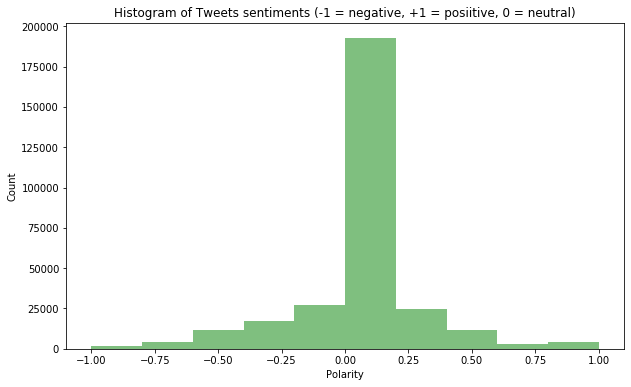

In [41]:
num_bins = 10
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(df1.polarity, num_bins, facecolor='green', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of Tweets sentiments (-1 = negative, +1 = posiitive, 0 = neutral)')
plt.show();